# Lesson 5a solutions: Filling histograms on a GPU

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import numba.cuda
import numba as nb
import uproot
import awkward as ak
from hist import Hist
ak.numba.register_and_check()

In [2]:
with uproot.open("../data/dimuon_mass.root:tree/mass") as branch:
    mass = cp.asarray(branch.array(library="np"))

mass

array([96.08437   , -1.        , 18.25135   , ..., 21.76483   ,
        0.6888827 ,  0.11970807], dtype=float32)

In [3]:
type(mass)

cupy.ndarray

In [4]:
@nb.cuda.jit(device=True)
def bin_index(x):
    if x < 0:
        return 0
    elif x >= 120:
        return 1199
    else:
        return x * 10

<br><br><br><br><br>

## Solutions to exercise 1

It won't be possible to fill this histogram using the method of filling thread-local copies concurrently and then adding up the results, because

* the histogram has 1200 bins
* the tasks that run concurrently are the CUDA threads, and there must be 10 million of them to process an input with 10 million elements.

Although most GPUs run fewer than 10 million threads at one time, they provision threads as though they would run at the same time ([concurrent, not necessarily parallel](https://jenkov.com/tutorials/java-concurrency/concurrency-vs-parallelism.html)). The threads might run in any order, so they each need their own copy of the histogram.

1200 bins × 10 million copies = 12 billion bins = 48 gigabytes of memory, which our GPU does not have.

Anyway, even if we did that, each thread would only fill one bin of its histogram, so most of the work of accumulating bin values would be in adding up the results—the post-processing step would be most of the processing.

Here is how it would be implemented. The following code will not run.

In [5]:
@nb.cuda.jit
def fill_histogram(all_histograms, mass):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(mass):
        my_bin_values = all_histograms[thread_idx]
        my_bin_values[bin_index(mass[thread_idx])] += 1

num_threads = 1024
num_blocks = int(np.ceil(len(mass) / 1024))

all_histograms = cp.zeros((10000000, 1200), dtype=np.uint32)

fill_histogram[num_blocks, num_threads](all_histograms, mass)

bin_values = cp.sum(all_histograms, axis=0)

OutOfMemoryError: Out of memory allocating 48,000,000,000 bytes (allocated so far: 40,000,000 bytes).

<br><br><br><br><br>

## Solutions to exercise 2

This is an example of a problem that atomics are good for.

In the lectures, I showed you a problem that they're not good for: adding up all values in an array, to get a single, scalar result. That was bad because every thread was trying to write to the same (single) value, and all but one had to wait their turn.

This is a good problem for atomics because each thread is likely filling a different `bin_values` element. The "contention" is low (not zero).

You could solve this problem with `nb.cuda.atomic.inc` (increment) or `nb.cuda.atomic.add` (addition); the first requires `bin_values` to be unsigned and the second requires `bin_values` to be signed, so you have to choose an operation and a `dtype` together.

Using `nb.cuda.atomic.inc` (with `-1` as the "reset value" because we don't want it to ever reset to zero),

In [6]:
@nb.cuda.jit
def fill_histogram(bin_values, mass):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(mass):
        nb.cuda.atomic.inc(bin_values, bin_index(mass[thread_idx]), -1)

num_threads = 1024
num_blocks = int(np.ceil(len(mass) / 1024))

bin_values = cp.zeros(1200, dtype=np.uint32)
fill_histogram[num_blocks, num_threads](bin_values, mass)

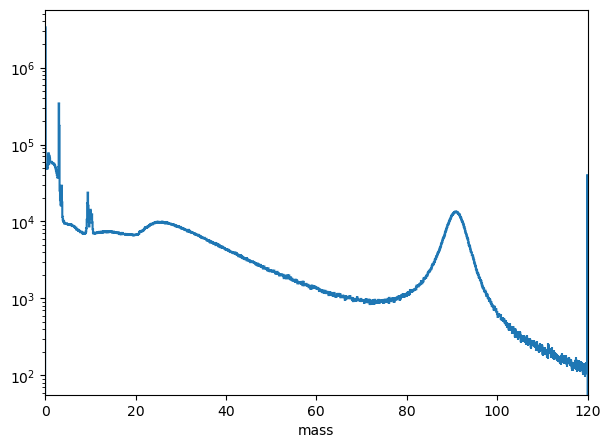

In [7]:
h = Hist.new.Reg(1200, 0, 120, label="mass").Double()
h.values()[:] = bin_values.get()

fig, ax = plt.subplots(figsize=(7, 5))
h.plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");

Using `nb.cuda.atomic.add`,

In [8]:
@nb.cuda.jit
def fill_histogram(bin_values, mass):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(mass):
        nb.cuda.atomic.add(bin_values, bin_index(mass[thread_idx]), 1)

num_threads = 1024
num_blocks = int(np.ceil(len(mass) / 1024))

bin_values = cp.zeros(1200, dtype=np.int32)
fill_histogram[num_blocks, num_threads](bin_values, mass)

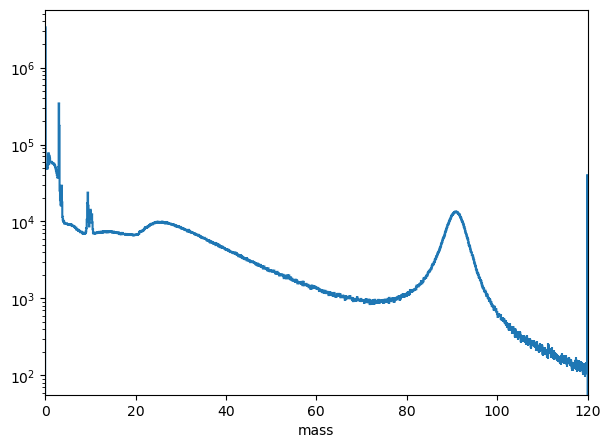

In [9]:
h = Hist.new.Reg(1200, 0, 120, label="mass").Double()
h.values()[:] = bin_values.get()

fig, ax = plt.subplots(figsize=(7, 5))
h.plot(ax=ax)
ax.set_xlim(0, 120)
ax.set_yscale("log");

<br><br><br><br><br>

With atomics, the histogram-filling is faster if there are _more_ bins, and if the statistical distribution is _broader_.

If there are _fewer_ bins, or the statistical distribution is _narrower_, then threads would more often be trying to write to the same `bin_values` element, and they would have to wait. To see this, let's make a histogram-filling process that scales the number of bins.

(This implementation, intended only for timing studies, doesn't fill the array correctly, so I'll use an array called `scratch_space` instead of `histogram`.)

In [10]:
@nb.cuda.jit(device=True)
def bin_index_atomic_varbins(num_bins, x):
    return np.uint32(num_bins * x / 120)

@nb.cuda.jit(device=True)
def fill_histogram_atomic_varbins(histogram, num_bins, x):
    if 0 <= x < 120:
        nb.cuda.atomic.inc(histogram, bin_index_atomic_varbins(num_bins, x), -1)

@nb.cuda.jit
def from_precomputed_histogram_atomic_varbins(mass, histogram, num_bins):
    thread_idx = nb.cuda.grid(1)
    if thread_idx < len(mass):
        fill_histogram_atomic_varbins(histogram, num_bins, mass[thread_idx])

scratch_space = cp.empty(1200, np.uint32)

from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 1200)

Now we can measure the time as we reduce the number of bins from 1200 down to 1.

In [11]:
number_of_bins = []
execution_time = []

In [12]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 1200)

1.73 ms ± 5.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 1.73 ms ± 5.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [13]:
number_of_bins.append(1200)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [14]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 800)

2.12 ms ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.12 ms ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [15]:
number_of_bins.append(800)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [16]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 600)

2.24 ms ± 3.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.24 ms ± 3.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [17]:
number_of_bins.append(600)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [18]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 400)

2.17 ms ± 2.19 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.17 ms ± 2.19 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [19]:
number_of_bins.append(400)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [20]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 300)

2.12 ms ± 7.59 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.12 ms ± 7.59 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [21]:
number_of_bins.append(300)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [22]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 150)

2.33 ms ± 38.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.33 ms ± 38.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [23]:
number_of_bins.append(150)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [24]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 75)

2.75 ms ± 2.13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.75 ms ± 2.13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [25]:
number_of_bins.append(75)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [26]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 60)

2.69 ms ± 6.11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.69 ms ± 6.11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [27]:
number_of_bins.append(60)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [28]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 30)

2.52 ms ± 4.35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.52 ms ± 4.35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [29]:
number_of_bins.append(30)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [30]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 15)

2.65 ms ± 1.69 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.65 ms ± 1.69 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [31]:
number_of_bins.append(15)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [32]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 10)

2.6 ms ± 6.04 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 2.6 ms ± 6.04 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [33]:
number_of_bins.append(10)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [34]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 5)

3.18 ms ± 1.51 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.18 ms ± 1.51 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [35]:
number_of_bins.append(5)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [36]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 4)

3.31 ms ± 2.44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.31 ms ± 2.44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [37]:
number_of_bins.append(4)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [38]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 3)

3.58 ms ± 6.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.58 ms ± 6.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [39]:
number_of_bins.append(3)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [40]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 2)

3.86 ms ± 1.82 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.86 ms ± 1.82 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [41]:
number_of_bins.append(2)
execution_time.append(np.mean(_.all_runs) / _.loops)

In [42]:
%%timeit -o
from_precomputed_histogram_atomic_varbins[num_blocks, num_threads](mass, scratch_space, 1)

3.89 ms ± 4.63 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 3.89 ms ± 4.63 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [43]:
number_of_bins.append(1)
execution_time.append(np.mean(_.all_runs) / _.loops)

What we find is that it generally gets worse with fewer bins—more contention—but not nearly as much as the reducer-based implementation.

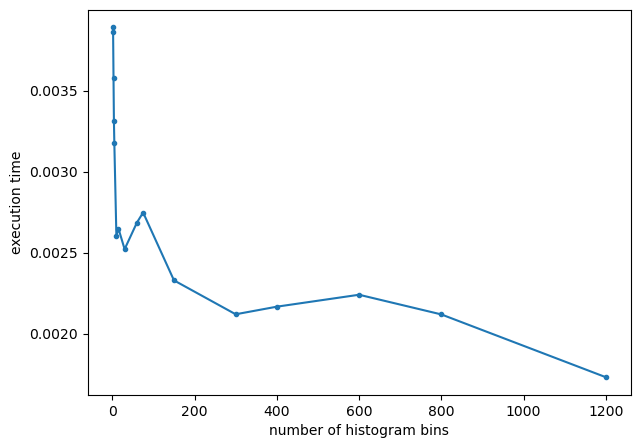

In [44]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(number_of_bins, execution_time, marker=".")
ax.set_xlabel("number of histogram bins")
ax.set_ylabel("execution time");